In [3]:
!git clone https://github.com/SiddharthMaverick/PCB_Defect_Classification_Deep_Learning.git

Cloning into 'pcb_defects_classification'...
remote: Enumerating objects: 14628, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 14628 (delta 3), reused 7 (delta 3), pack-reused 14616
Receiving objects: 100% (14628/14628), 95.24 MiB | 21.42 MiB/s, done.
Resolving deltas: 100% (4117/4117), done.
Updating files: 100% (14539/14539), done.


In [4]:
%cd pcb_defects_classification

/content/pcb_defects_classification


In [83]:
import os
from tools import config

if not os.path.exists(config.DEFECTS_PATH):
    !python "tools/extracted_defetcs.py"

In [6]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import cv2

In [7]:
datagenAug = ImageDataGenerator(
    rotation_range=90,
	zoom_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	validation_split=0.2
)

In [8]:
trainGen = datagenAug.flow_from_directory(
    config.DEFECTS_PATH, classes=config.CLASSES,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="training")

testGen = datagenAug.flow_from_directory(
    config.DEFECTS_PATH, classes=config.CLASSES,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="validation")

Found 8012 images belonging to 6 classes.
Found 2001 images belonging to 6 classes.


In [9]:
resnet_model = InceptionV3(weights='imagenet', include_top=False,  input_tensor=Input(shape=(224, 224, 3)))

for layer in resnet_model.layers[:-1]:
    layer.trainable = False

head = resnet_model.output
head = GlobalAveragePooling2D()(head)
fc = Dense(1024, activation = "relu")(head)
fc = Dropout(0.2)(fc)
output = Dense(len(trainGen.class_indices), activation = "softmax")(fc)

model = Model(inputs=resnet_model.input, outputs=output)

87910968/87910968 [==============================] - 0s 0us/step


In [10]:
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
checkpoint = ModelCheckpoint(os.path.sep.join([config.OUTPUT_PATH, "inceptionV3.h5"]), monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=100, verbose=1, mode='auto')

In [12]:
hist = model.fit(
    trainGen, steps_per_epoch=trainGen.samples // 32,
	validation_data=testGen, validation_steps=testGen.samples // 32,
	epochs=15, callbacks=[checkpoint, early])

model.save(os.path.sep.join([config.OUTPUT_PATH, "inceptionV3.model"]), save_format='h5')

Epoch 1/15

Epoch 1: accuracy improved from -inf to 0.21875, saving model to output/inceptionV3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
 10/250 [>.............................] - ETA: 1:32 - loss: 0.5469 - accuracy: 0.8438
Epoch 6: accuracy did not improve from 0.87500
 11/250 [>.............................] - ETA: 1:31 - loss: 0.5304 - accuracy: 0.8494
Epoch 6: accuracy did not improve from 0.87500
 12/250 [>.............................] - ETA: 1:31 - loss: 0.5091 - accuracy: 0.8568
Epoch 6: accuracy did not improve from 0.87500
 13/250 [>.............................] - ETA: 1:30 - loss: 0.5349 - accuracy: 0.8558
Epoch 6: accuracy did not improve from 0.87500
 14/250 [>.............................] - ETA: 1:30 - loss: 0.5519 - accuracy: 0.8527
Epoch 6: accuracy did not improve from 0.87500
 15/250 [>.............................] - ETA: 1:30 - loss: 0.5919 - accuracy: 0.8500
Epoch 6: accuracy did not improve from 0.87500
 16/250 [>.............................] - ETA: 1:29 - loss: 0.6077 - accuracy: 0.8477
Epoch 6: accuracy did not improve from 0.87500
 17/250 [=>

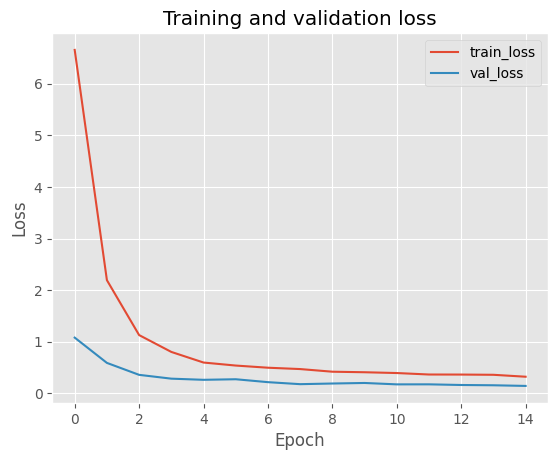

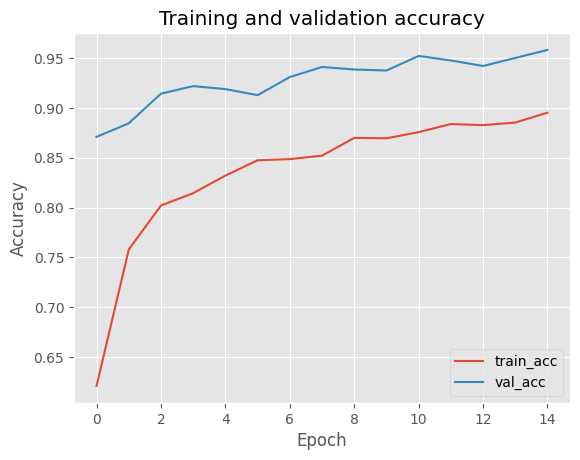

In [13]:
N = np.arange(0, 15)
plt.style.use("ggplot")

plt.figure()
plt.plot(N, hist.history["loss"], label="train_loss")
plt.plot(N, hist.history["val_loss"], label="val_loss")
plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.sep.join([config.OUTPUT_PATH, "inception_losses.png"]))

plt.figure()
plt.plot(N, hist.history["accuracy"], label="train_acc")
plt.plot(N, hist.history["val_accuracy"], label="val_acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.sep.join([config.OUTPUT_PATH, "inception_accuracy.png"]))

plt.show()

In [84]:
from tensorflow.keras.models import load_model
model = load_model(os.path.sep.join([config.OUTPUT_PATH, "inceptionV3.model"]))

              precision    recall  f1-score   support

        open      0.897     0.874     0.885       388
       short      0.625     0.924     0.745       301
    mousebit      0.878     0.623     0.729       393
        spur      0.694     0.831     0.756       325
      copper      0.919     0.929     0.924       294
    pin-hole      0.944     0.670     0.784       300

    accuracy                          0.803      2001
   macro avg      0.826     0.808     0.804      2001
weighted avg      0.830     0.803     0.803      2001



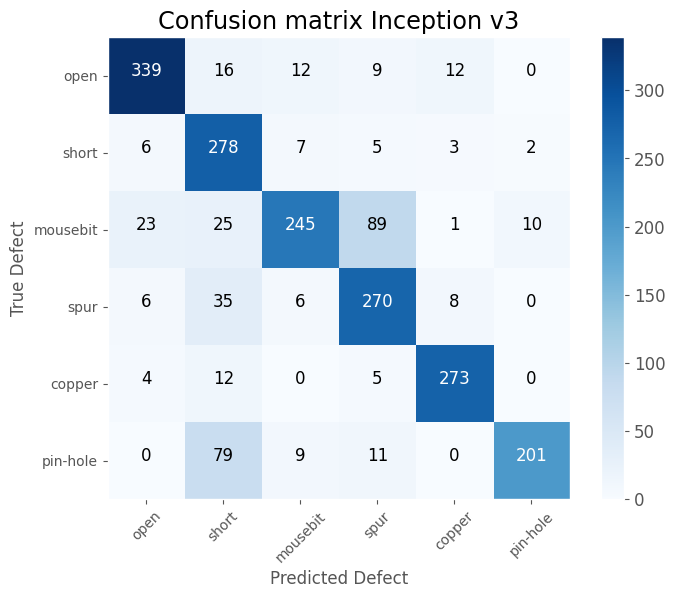

In [85]:
import os
import sys

# Suppressing the iteration updates
with open(os.devnull, 'w') as devnull:
    old_stdout = sys.stdout
    sys.stdout = devnull

    predictions = []
    for path in testGen.filepaths:
        image = cv2.imread(path)
        image = cv2.resize(image, (224, 224))
        image = np.expand_dims(image, axis=0)
        preds = model.predict(image)
        predictions.append(preds.argmax(axis=1))

    sys.stdout = old_stdout  # Restore stdout

predictions = np.concatenate(predictions)  # Flatten the list of predictions

print(classification_report(testGen.classes,
                            predictions,
                            target_names=testGen.class_indices,
                            digits=3))

plt.style.use("ggplot")
plt.grid(False)
plt.rcParams["figure.figsize"] = (8, 6)
font = {'size': 12}
plt.rc('font', **font)

cm = confusion_matrix(testGen.classes, predictions)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(testGen.class_indices))

plt.xticks(tick_marks, testGen.class_indices, rotation=45)
plt.yticks(tick_marks, testGen.class_indices)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Defect')
plt.ylabel('True Defect')
plt.title('Confusion matrix Inception v3')
plt.savefig('output/inception_confusion_matrix.png')
plt.show()


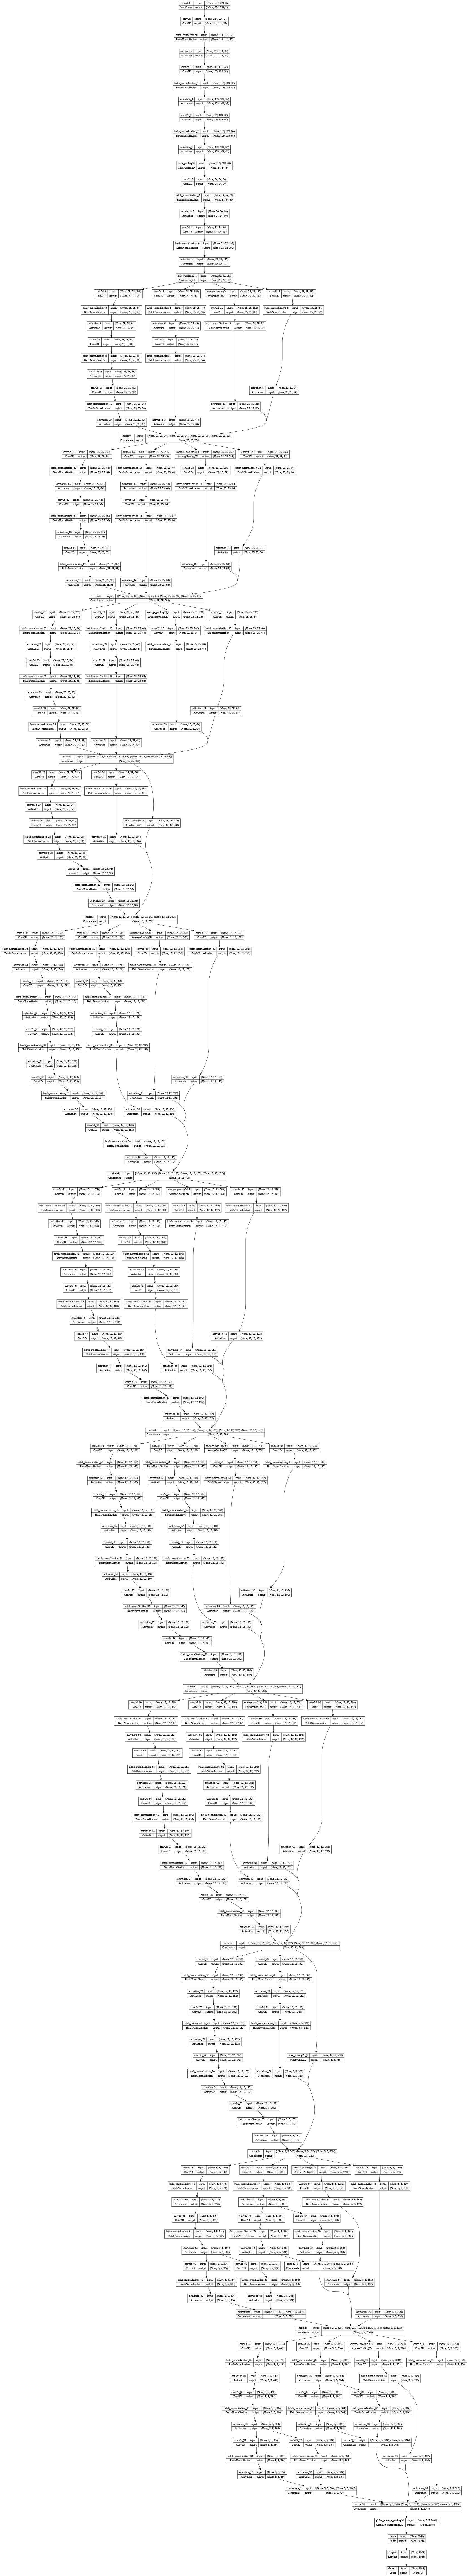

In [86]:
from keras.models import load_model
from tensorflow.keras.utils import plot_model

# Load the saved model
model = load_model(os.path.sep.join([config.OUTPUT_PATH, "inceptionV3.model"]))

# Visualize the architecture with reduced size
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, dpi=50)